<a href="https://colab.research.google.com/github/AhamedShimak/My_GANs/blob/main/MakeMe_V-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Shimak generator V01/V01.1

###imports

In [1]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
from torch import nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary
from tqdm.auto import tqdm

import sklearn
from sklearn.model_selection import train_test_split

###GPU 

In [3]:
!nvidia-smi
print(torch.cuda.is_available())
#setup device agnostic code
device="cuda" if torch.cuda.is_available() else "cpu"
print(device)


/bin/bash: nvidia-smi: command not found
False
cpu


# Load Dataset


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import cv2

def convert_video_to_images(video_path, output_path):
    video_capture = cv2.VideoCapture(video_path)
    frame_count = 0

    while True:
        success, frame = video_capture.read()
        if not success:
            break

        output_file = f"{output_path}/{frame_count}.jpg"
        cv2.imwrite(output_file, frame)

        frame_count += 1

    video_capture.release()

# Usage example

convert_video_to_images("/content/drive/MyDrive/AI/shimak.mp4", output_path="/content/drive/MyDrive/AI/shimak")



###data transforms / for good perfomance

In [6]:
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize image to (224, 224)
    #transforms.TrivialAugmentWide(2),

    transforms.ToTensor(),  # Convert PIL image to tensor
    #transforms.RandomHorizontalFlip(0.5) # Normalize image tensor
])

In [7]:
from torchvision import datasets
trainset=datasets.ImageFolder(root="/content/drive/MyDrive/AI/data",transform=data_transform, target_transform=None)

1302

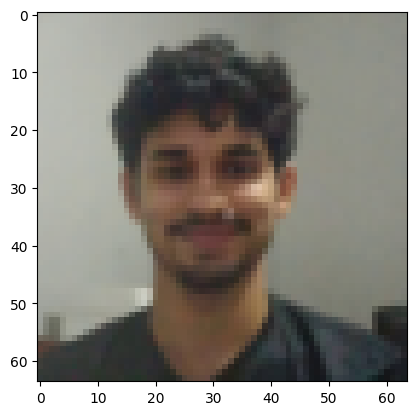

In [8]:
image,label=trainset[7]
plt.imshow(image.squeeze().permute(1,2,0))
len(trainset)

# Data load / batch ready!

In [9]:
batch_size=128

In [10]:
trainloader=DataLoader(trainset,batch_size=batch_size, shuffle=True)

In [11]:
len(trainloader)

11

torch.Size([3, 64, 64])
tensor(0)


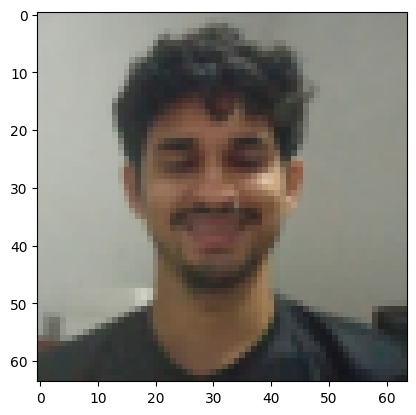

In [12]:
images, label = next(iter(trainloader))
print(images[0].shape)
#print(images[0])
plt.imshow(images[0].permute(1,2,0))
print(label[0])

In [25]:
# plot in sub plots //grayscale

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.axis(False)
    plt.show()

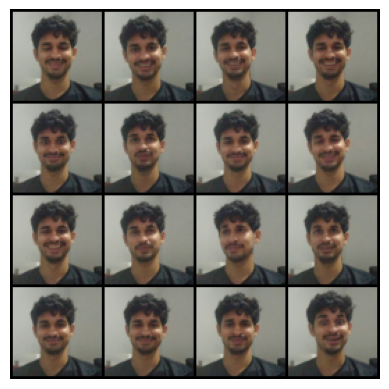

In [28]:
show_tensor_images(images)

# Building the model | Discriminator

In [ ]:
# def get_disc_block(in_channels, out_channels, kernel_size,stride):
#   return nn.Sequential(
#       nn.Conv2d(in_channels, out_channels,kernel_size,stride),
#       nn.BatchNorm2d(out_channels),
#       nn.LeakyReLU(0,2)
#   )



In [16]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()

    self.block_1 = nn.Sequential(
  # in: 3 x 64 x 64

  nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
  nn.BatchNorm2d(64),
  nn.LeakyReLU(0.2, inplace=True),
  # out: 64 x 32 x 32

  nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
  nn.BatchNorm2d(128),
  nn.LeakyReLU(0.2, inplace=True),
  # out: 128 x 16 x 16

  nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
  nn.BatchNorm2d(256),
  nn.LeakyReLU(0.2, inplace=True),
  # out: 256 x 8 x 8

  nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
  nn.BatchNorm2d(512),
  nn.LeakyReLU(0.2, inplace=True),
  # out: 512 x 4 x 4

  nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
  # out: 1 x 1 x 1

  nn.Flatten(),
  nn.Sigmoid())
  def forward(self,x: torch.Tensor) -> torch.Tensor:
    return self.block_1(x)

In [17]:
discriminator= Discriminator()
discriminator.to(device)
summary(discriminator, input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           8,192
          Flatten-14                   

# Create Generator Network 

In [ ]:
# def get_gen_block(in_channels, out_channels, kernel_size,stride):
#   return nn.Sequential(
#       nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
#       nn.BatchNorm2d(out_channels),
#       nn.ReLU()
#   )

In [18]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(128, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [ ]:
# class Generator(nn.Module):

#   def __init__(self, noise_dim):
#     super(Generator,self).__init__()

#     self.block_1 =get_gen_block(noise_dim,256,(3,3),2)
#     self.block_2 =get_gen_block(256,128,(4,4),1)
#     self.block_3 =get_gen_block(128,64,(3,3),2)

#     self.image_gen_block=nn.Sequential(
#         nn.ConvTranspose2d(64,3,(4,4),2),
#         nn.Sigmoid(),
#     )
#   def forward(self, r_noise_dim):
#     x= r_noise_dim.view(-1,self.noise_dim,1,1)
#     return self.image_gen_block(self.block_3(self.block_2(self.block_1(x))))

In [19]:
latent_size=128

In [20]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [30]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

torch.Size([128, 3, 64, 64])


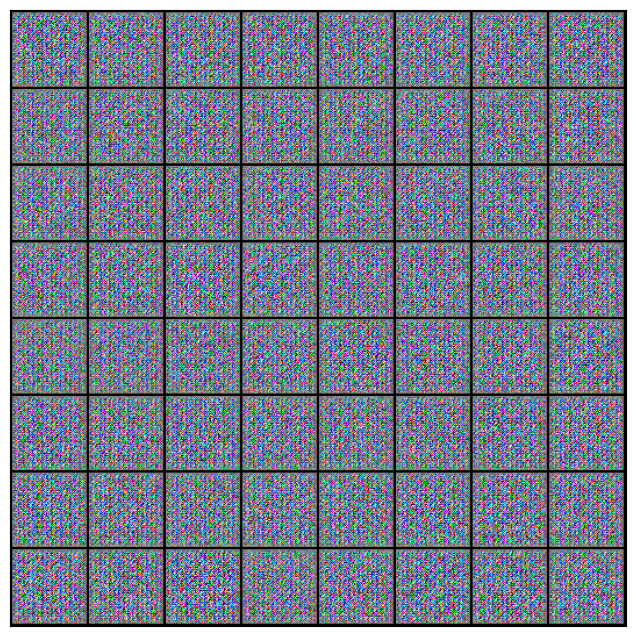

In [32]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [33]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [35]:
def train_discriminator(real_images, optimizer_d):
    # Clear discriminator gradients
    optimizer_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    optimizer_d.step()
    return loss.item(), real_score, fake_score

In [36]:
def train_generator(optimizer_g):
    # Clear generator gradients
    optimizer_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    optimizer_g.step()
    
    return loss.item()

In [37]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)


In [50]:
from torchvision.utils import save_image
import os

sample_dir = '/content/drive/MyDrive/AI/generated'
os.makedirs(sample_dir, exist_ok=True)
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))

In [51]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(trainloader):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [52]:
lr = 0.002
epochs = 100

In [53]:
history = fit(epochs, lr)

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 4.3932, loss_d: 1.8181, real_score: 0.9048, fake_score: 0.8155
Saving generated-images-0001.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 6.5883, loss_d: 1.4644, real_score: 0.9737, fake_score: 0.7412
Saving generated-images-0002.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 7.6556, loss_d: 0.8237, real_score: 0.9878, fake_score: 0.5160
Saving generated-images-0003.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 8.1902, loss_d: 3.3392, real_score: 0.9985, fake_score: 0.9388
Saving generated-images-0004.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 0.6130, loss_d: 1.5803, real_score: 0.2285, fake_score: 0.0802
Saving generated-images-0005.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 4.2388, loss_d: 0.9048, real_score: 0.9410, fake_score: 0.5540
Saving generated-images-0006.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 2.8783, loss_d: 1.6410, real_score: 0.2467, fake_score: 0.0057
Saving generated-images-0007.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 2.7168, loss_d: 0.7658, real_score: 0.5247, fake_score: 0.0798
Saving generated-images-0008.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 0.4470, loss_d: 0.9178, real_score: 0.6769, fake_score: 0.3913
Saving generated-images-0009.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 0.4118, loss_d: 1.5541, real_score: 0.2465, fake_score: 0.1157
Saving generated-images-0010.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 3.5097, loss_d: 1.6488, real_score: 0.9083, fake_score: 0.7851
Saving generated-images-0011.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 2.8751, loss_d: 0.7643, real_score: 0.9004, fake_score: 0.4801
Saving generated-images-0012.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 0.6754, loss_d: 1.2270, real_score: 0.3690, fake_score: 0.1588
Saving generated-images-0013.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 1.4599, loss_d: 0.8648, real_score: 0.6244, fake_score: 0.2786
Saving generated-images-0014.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 1.6465, loss_d: 1.0135, real_score: 0.5726, fake_score: 0.3610
Saving generated-images-0015.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 0.6654, loss_d: 2.2736, real_score: 0.1177, fake_score: 0.0357
Saving generated-images-0016.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 3.9514, loss_d: 1.4731, real_score: 0.7489, fake_score: 0.6863
Saving generated-images-0017.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 6.7193, loss_d: 0.7502, real_score: 0.8910, fake_score: 0.4636
Saving generated-images-0018.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 0.1498, loss_d: 2.2885, real_score: 0.1165, fake_score: 0.0437
Saving generated-images-0019.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 2.7217, loss_d: 1.0938, real_score: 0.8906, fake_score: 0.6217
Saving generated-images-0020.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 0.9464, loss_d: 1.2399, real_score: 0.3415, fake_score: 0.0776
Saving generated-images-0021.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 3.1450, loss_d: 1.3403, real_score: 0.9369, fake_score: 0.7175
Saving generated-images-0022.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 3.1392, loss_d: 0.7793, real_score: 0.6602, fake_score: 0.2963
Saving generated-images-0023.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 1.0149, loss_d: 2.5939, real_score: 0.0964, fake_score: 0.0059
Saving generated-images-0024.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 3.6905, loss_d: 1.3884, real_score: 0.9425, fake_score: 0.7292
Saving generated-images-0025.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 0.5230, loss_d: 1.7930, real_score: 0.1805, fake_score: 0.0616
Saving generated-images-0026.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 2.8357, loss_d: 0.5295, real_score: 0.8555, fake_score: 0.3033
Saving generated-images-0027.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 0.5518, loss_d: 1.4937, real_score: 0.2704, fake_score: 0.0521
Saving generated-images-0028.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 0.8173, loss_d: 0.7941, real_score: 0.7125, fake_score: 0.3573
Saving generated-images-0029.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 4.0381, loss_d: 0.8458, real_score: 0.8846, fake_score: 0.5113
Saving generated-images-0030.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 1.1963, loss_d: 1.3347, real_score: 0.3279, fake_score: 0.0967
Saving generated-images-0031.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 2.0259, loss_d: 0.7465, real_score: 0.5357, fake_score: 0.0672
Saving generated-images-0032.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 2.5131, loss_d: 0.8824, real_score: 0.6677, fake_score: 0.3669
Saving generated-images-0033.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 1.7390, loss_d: 2.8215, real_score: 0.0649, fake_score: 0.0077
Saving generated-images-0034.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 1.0992, loss_d: 0.8458, real_score: 0.5483, fake_score: 0.1979
Saving generated-images-0035.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 5.9779, loss_d: 0.3964, real_score: 0.9362, fake_score: 0.2773
Saving generated-images-0036.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 4.5654, loss_d: 0.9952, real_score: 0.9121, fake_score: 0.5919
Saving generated-images-0037.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 0.5006, loss_d: 0.7617, real_score: 0.6806, fake_score: 0.3062
Saving generated-images-0038.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 0.3736, loss_d: 1.1843, real_score: 0.5050, fake_score: 0.2927
Saving generated-images-0039.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 4.1418, loss_d: 0.8333, real_score: 0.9037, fake_score: 0.5059
Saving generated-images-0040.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 3.8876, loss_d: 1.2915, real_score: 0.9074, fake_score: 0.6938
Saving generated-images-0041.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 3.3963, loss_d: 1.0807, real_score: 0.3921, fake_score: 0.0084
Saving generated-images-0042.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 2.8570, loss_d: 0.6266, real_score: 0.9097, fake_score: 0.4107
Saving generated-images-0043.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 0.2849, loss_d: 0.6887, real_score: 0.5938, fake_score: 0.1288
Saving generated-images-0044.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 3.4513, loss_d: 0.1102, real_score: 0.9566, fake_score: 0.0634
Saving generated-images-0045.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 2.6270, loss_d: 1.0311, real_score: 0.4049, fake_score: 0.0135
Saving generated-images-0046.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 1.4301, loss_d: 0.4762, real_score: 0.9040, fake_score: 0.3114
Saving generated-images-0047.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 3.3971, loss_d: 0.4867, real_score: 0.6599, fake_score: 0.0339
Saving generated-images-0048.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 5.0462, loss_d: 0.4244, real_score: 0.9371, fake_score: 0.2976
Saving generated-images-0049.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 2.7132, loss_d: 2.3365, real_score: 0.1748, fake_score: 0.0029
Saving generated-images-0050.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 2.8039, loss_d: 0.5380, real_score: 0.8035, fake_score: 0.2702
Saving generated-images-0051.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 7.5415, loss_d: 3.5667, real_score: 0.9757, fake_score: 0.9680
Saving generated-images-0052.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 4.4519, loss_d: 0.2496, real_score: 0.8874, fake_score: 0.1162
Saving generated-images-0053.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 2.8875, loss_d: 0.9045, real_score: 0.6927, fake_score: 0.4006
Saving generated-images-0054.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 1.1725, loss_d: 3.2101, real_score: 0.0477, fake_score: 0.0034
Saving generated-images-0055.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 2.8997, loss_d: 0.2338, real_score: 0.8584, fake_score: 0.0606
Saving generated-images-0056.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 2.1986, loss_d: 0.4948, real_score: 0.6543, fake_score: 0.0626
Saving generated-images-0057.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 3.7483, loss_d: 0.3352, real_score: 0.8914, fake_score: 0.1926
Saving generated-images-0058.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 8.5305, loss_d: 1.5233, real_score: 0.8304, fake_score: 0.7191
Saving generated-images-0059.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 0.8526, loss_d: 1.2348, real_score: 0.3961, fake_score: 0.2121
Saving generated-images-0060.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 2.0611, loss_d: 1.1903, real_score: 0.8233, fake_score: 0.6247
Saving generated-images-0061.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 5.8901, loss_d: 1.4288, real_score: 0.9413, fake_score: 0.7431
Saving generated-images-0062.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 1.0416, loss_d: 0.8704, real_score: 0.4907, fake_score: 0.0839
Saving generated-images-0063.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 1.0636, loss_d: 1.8467, real_score: 0.1853, fake_score: 0.0566
Saving generated-images-0064.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 1.2723, loss_d: 0.7910, real_score: 0.5509, fake_score: 0.1422
Saving generated-images-0065.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 2.9798, loss_d: 0.5737, real_score: 0.9474, fake_score: 0.3996
Saving generated-images-0066.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 3.0784, loss_d: 0.3559, real_score: 0.9771, fake_score: 0.2809
Saving generated-images-0067.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 3.1849, loss_d: 0.8865, real_score: 0.7951, fake_score: 0.4755
Saving generated-images-0068.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 0.9601, loss_d: 2.2650, real_score: 0.1287, fake_score: 0.0360
Saving generated-images-0069.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 2.3011, loss_d: 0.8363, real_score: 0.6408, fake_score: 0.2239
Saving generated-images-0070.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 0.7434, loss_d: 1.2601, real_score: 0.6277, fake_score: 0.5174
Saving generated-images-0071.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 3.8609, loss_d: 1.3958, real_score: 0.9415, fake_score: 0.7333
Saving generated-images-0072.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 0.5203, loss_d: 1.3027, real_score: 0.3108, fake_score: 0.0741
Saving generated-images-0073.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 3.0127, loss_d: 0.6649, real_score: 0.7718, fake_score: 0.3241
Saving generated-images-0074.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 0.6738, loss_d: 2.1139, real_score: 0.1804, fake_score: 0.0505
Saving generated-images-0075.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 2.8093, loss_d: 0.9704, real_score: 0.7518, fake_score: 0.4794
Saving generated-images-0076.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 0.7006, loss_d: 0.6992, real_score: 0.6892, fake_score: 0.2206
Saving generated-images-0077.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 1.5227, loss_d: 0.7039, real_score: 0.6378, fake_score: 0.2056
Saving generated-images-0078.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 1.6546, loss_d: 1.1037, real_score: 0.3775, fake_score: 0.0943
Saving generated-images-0079.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 1.3697, loss_d: 2.6478, real_score: 0.0788, fake_score: 0.0057
Saving generated-images-0080.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 4.1594, loss_d: 1.4182, real_score: 0.8602, fake_score: 0.7126
Saving generated-images-0081.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 0.6934, loss_d: 0.5955, real_score: 0.6509, fake_score: 0.1362
Saving generated-images-0082.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 1.0480, loss_d: 1.0091, real_score: 0.4409, fake_score: 0.1588
Saving generated-images-0083.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 2.7042, loss_d: 1.0160, real_score: 0.8602, fake_score: 0.5703
Saving generated-images-0084.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 0.9978, loss_d: 1.0319, real_score: 0.4475, fake_score: 0.1590
Saving generated-images-0085.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 3.5558, loss_d: 1.3586, real_score: 0.8910, fake_score: 0.7089
Saving generated-images-0086.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 1.1874, loss_d: 0.8616, real_score: 0.5153, fake_score: 0.1578
Saving generated-images-0087.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 0.3426, loss_d: 1.8721, real_score: 0.1690, fake_score: 0.0387
Saving generated-images-0088.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 2.2791, loss_d: 0.5587, real_score: 0.6572, fake_score: 0.1013
Saving generated-images-0089.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 0.5244, loss_d: 1.2058, real_score: 0.4038, fake_score: 0.2134
Saving generated-images-0090.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 2.4949, loss_d: 1.3434, real_score: 0.7426, fake_score: 0.6408
Saving generated-images-0091.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 0.9799, loss_d: 1.0574, real_score: 0.4138, fake_score: 0.1182
Saving generated-images-0092.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 3.2302, loss_d: 0.9743, real_score: 0.8012, fake_score: 0.5157
Saving generated-images-0093.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 1.5675, loss_d: 0.7783, real_score: 0.6642, fake_score: 0.2858
Saving generated-images-0094.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 3.1663, loss_d: 0.8817, real_score: 0.8378, fake_score: 0.4892
Saving generated-images-0095.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 2.6509, loss_d: 0.7520, real_score: 0.8272, fake_score: 0.4227
Saving generated-images-0096.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 1.4263, loss_d: 0.6851, real_score: 0.6577, fake_score: 0.2235
Saving generated-images-0097.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 0.4306, loss_d: 1.2558, real_score: 0.3320, fake_score: 0.1161
Saving generated-images-0098.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 5.6117, loss_d: 1.3333, real_score: 0.9038, fake_score: 0.6984
Saving generated-images-0099.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 5.1010, loss_d: 1.5102, real_score: 0.8954, fake_score: 0.7416
Saving generated-images-0100.png


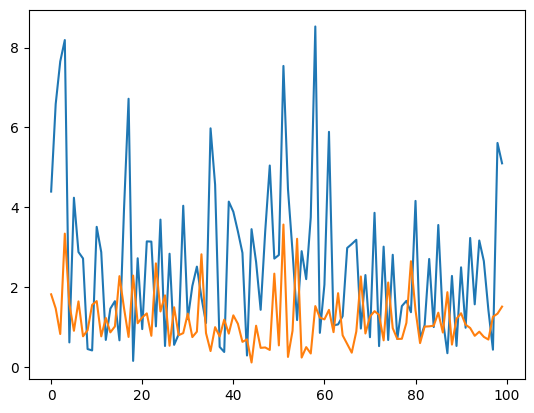

In [61]:
plt.plot(history[0])
plt.plot(history[1])

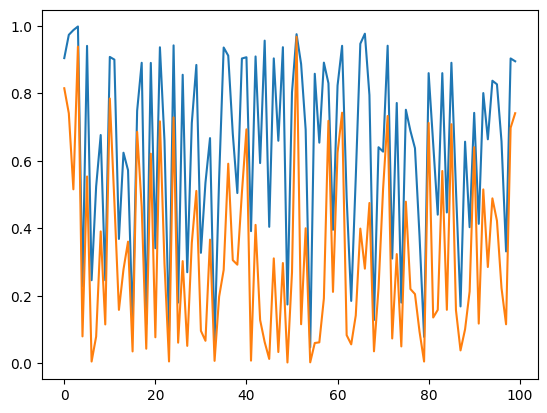

In [62]:
plt.plot(history[2])
plt.plot(history[3])

In [63]:
from IPython.display import Image


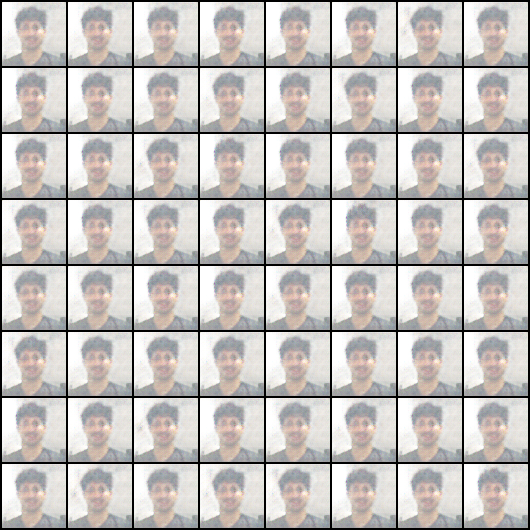

In [48]:
Image('./generated/generated-images-0022.png')


torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])
torch.Size([128, 3, 64, 64])


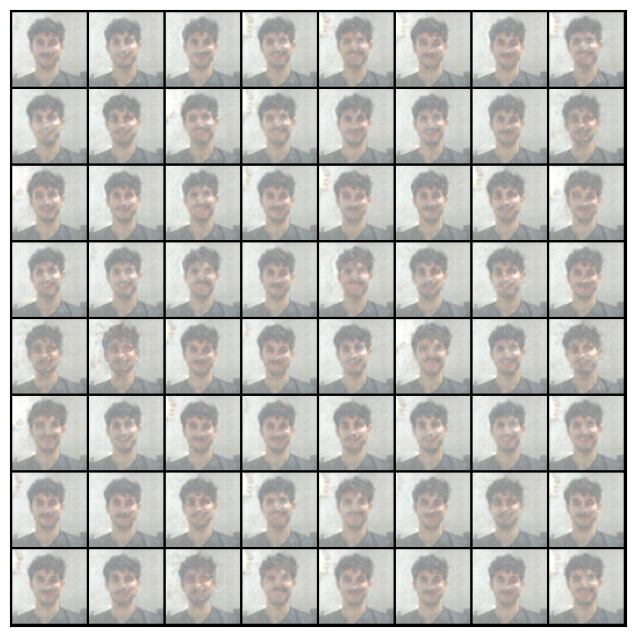

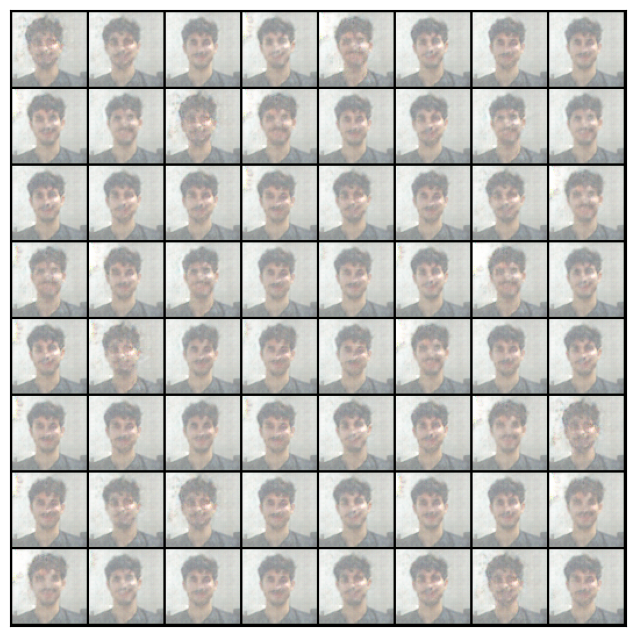

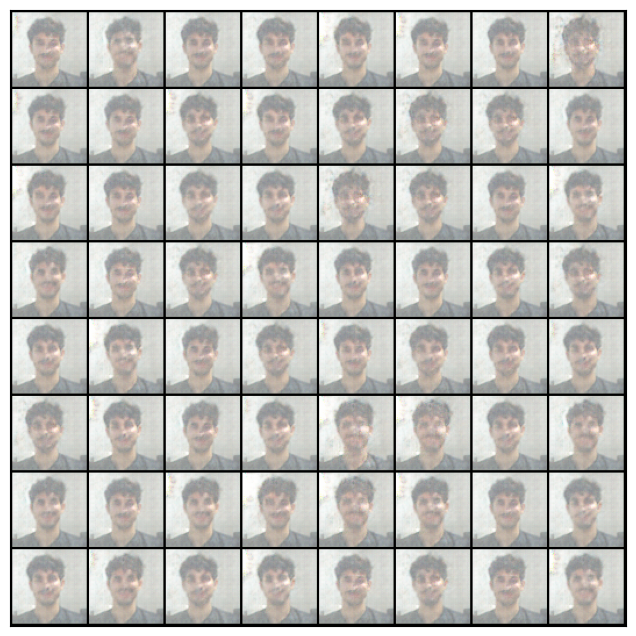

In [65]:
for i in range(3): 
  xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
  fake_images = generator(xb)
  print(fake_images.shape)
  show_images(fake_images)

In [ ]:
# noise_dim=128
# #G= Generator(noise_dim)
# G.to(device)
# summary(G, input_size=(1,noise_dim))

In [ ]:
# # Replace Random initialized weights to Normal weights  
# def weights_init(m):  
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
#         nn.init.normal_(m.weight, 0.0, 0.02)
#     if isinstance(m, nn.BatchNorm2d):
#         nn.init.normal_(m.weight, 0.0, 0.02)
#         nn.init.constant_(m.bias, 0)

In [ ]:
# D=D.apply(weights_init)
# G=G.apply(weights_init)

# Optimizer



In [ ]:
# # optim para

# lr=0.001
# beta_1=0.5
# beta_2=0.99



In [ ]:
# D_opt=torch.optim.Adam(D.parameters(),lr=0.001,betas=(beta_1,beta_2))
# G_opt=torch.optim.Adam(G.parameters(),lr=0.005,betas=(beta_1,beta_2))

# Training Loop 

In [ ]:
# G_loss_track=[]
# D_loss_track=[]
# def real_loss(disc_pred):
#   loss_func=nn.BCEWithLogitsLoss()
#   ground_truth=torch.ones_like(disc_pred) #creating zeros with matching size of disc_pred
#   loss =loss_func(disc_pred,ground_truth)
#   return loss

# def real_loss_g(disc_pred):
#   loss_func=nn.MSELoss()
#   ground_truth=torch.ones_like(disc_pred) #creating zeros with matching size of disc_pred
#   loss =loss_func(disc_pred,ground_truth)
#   return loss

# def fake_loss(disc_pred):
#   loss_func=nn.BCEWithLogitsLoss()
#   ground_truth=torch.zeros_like(disc_pred) #creating zeros with matching size of disc_pred
#   loss =loss_func(disc_pred,ground_truth)
#   return loss

# #training_var
# epochs=100

# for  i in range(epochs):
#   total_d_loss=0.0
#   total_g_loss=0.0

#   for real_img, _ in tqdm(trainloader):
#     real_img= real_img.to(device)#####
#     noise=torch.randn(batch_size,noise_dim,device = device)

#     #pred_discriminator
#     fake_img=G(noise)#####
#     D_pred=D(fake_img)

#     #loss_calculation
#     D_loss_to_increase=fake_loss(D_pred)

#     D_pred=D(real_img)
#     D_loss_to_reduce=real_loss(D_pred)

    
#     D_loss=(D_loss_to_increase + D_loss_to_reduce)/2

#     total_d_loss += D_loss.item()


#     D_opt.zero_grad()
#     D_loss.backward()
#     D_opt.step()

#     #generator_side #################################
#     noise=torch.randn(batch_size,noise_dim,device = device)

#     fake_img=G(noise)
#     D_pred=D(fake_img)
#     G_loss=real_loss_g(D_pred)

#     total_g_loss += G_loss.item()

#     G_opt.zero_grad()
#     G_loss.backward()
#     G_opt.step()
  
#   avg_d_loss=total_d_loss/len(trainloader)
#   avg_g_loss=total_g_loss/len(trainloader)
#   G_loss_track.append(avg_g_loss)
#   D_loss_track.append(avg_d_loss)
#   print("Epoch: {} | D_loss:{} | G_loss{}".format(i+1, avg_d_loss,avg_g_loss))
#   show_tensor_images(fake_img)

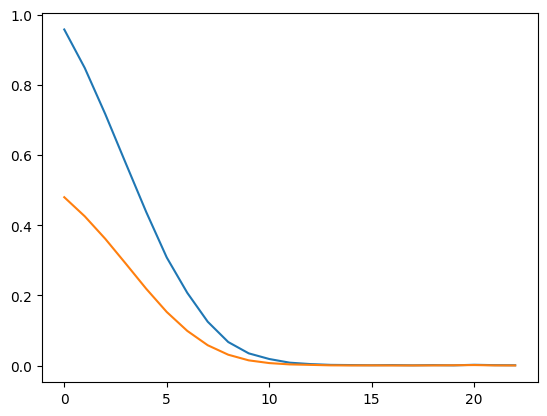

In [ ]:
#   plt.plot(G_loss_track)
# plt.plot(D_loss_track)

In [ ]:
# avg_g_loss

0.00023292791510440028

##EVALUATION

In [ ]:
# fake_img[0].shape

torch.Size([3, 28, 28])

In [ ]:
# real_img[0]

tensor([[[0.7333, 0.7333, 0.7333,  ..., 0.5804, 0.5765, 0.5686],
         [0.7451, 0.7451, 0.7373,  ..., 0.5843, 0.5765, 0.5725],
         [0.7490, 0.7412, 0.7373,  ..., 0.5882, 0.5843, 0.5804],
         ...,
         [0.3412, 0.3098, 0.2784,  ..., 0.1804, 0.1765, 0.1412],
         [0.2392, 0.2314, 0.2314,  ..., 0.1765, 0.1765, 0.1529],
         [0.2275, 0.2235, 0.2196,  ..., 0.1843, 0.1255, 0.1059]],

        [[0.7451, 0.7451, 0.7412,  ..., 0.5804, 0.5765, 0.5765],
         [0.7569, 0.7529, 0.7451,  ..., 0.5882, 0.5843, 0.5804],
         [0.7608, 0.7529, 0.7451,  ..., 0.5922, 0.5922, 0.5882],
         ...,
         [0.2784, 0.2824, 0.2863,  ..., 0.2157, 0.2000, 0.1647],
         [0.2510, 0.2431, 0.2431,  ..., 0.2157, 0.2039, 0.1804],
         [0.2392, 0.2314, 0.2314,  ..., 0.2078, 0.1412, 0.1216]],

        [[0.7176, 0.7176, 0.7137,  ..., 0.5529, 0.5451, 0.5333],
         [0.7294, 0.7255, 0.7137,  ..., 0.5529, 0.5490, 0.5529],
         [0.7333, 0.7255, 0.7137,  ..., 0.5569, 0.5529, 0.

In [ ]:
# fake_img[0]

tensor([[[0.5159, 0.5476, 0.4966,  ..., 0.5402, 0.5111, 0.5350],
         [0.5367, 0.5180, 0.5267,  ..., 0.4896, 0.5361, 0.5215],
         [0.5067, 0.5277, 0.4798,  ..., 0.4889, 0.5001, 0.5200],
         ...,
         [0.5480, 0.4912, 0.5426,  ..., 0.4394, 0.5383, 0.5088],
         [0.5300, 0.5274, 0.5180,  ..., 0.4986, 0.5198, 0.5204],
         [0.5490, 0.5013, 0.5556,  ..., 0.4740, 0.5438, 0.5172]],

        [[0.4907, 0.4989, 0.4696,  ..., 0.4707, 0.4798, 0.4877],
         [0.4848, 0.5008, 0.4744,  ..., 0.4725, 0.5032, 0.4907],
         [0.4837, 0.4990, 0.4374,  ..., 0.4261, 0.4550, 0.4633],
         ...,
         [0.4743, 0.4874, 0.4605,  ..., 0.4288, 0.5088, 0.4787],
         [0.4975, 0.5062, 0.4771,  ..., 0.4668, 0.4832, 0.4767],
         [0.4893, 0.4904, 0.4889,  ..., 0.4595, 0.5080, 0.4872]],

        [[0.4333, 0.4689, 0.4105,  ..., 0.4634, 0.4372, 0.4676],
         [0.4530, 0.4574, 0.4405,  ..., 0.4379, 0.4593, 0.4552],
         [0.4337, 0.4590, 0.3740,  ..., 0.4302, 0.4123, 0.

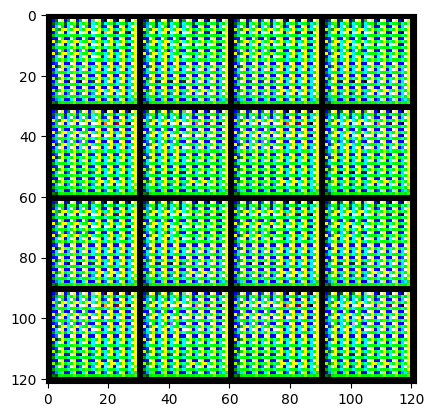

In [ ]:
# show_tensor_images(fake_img)

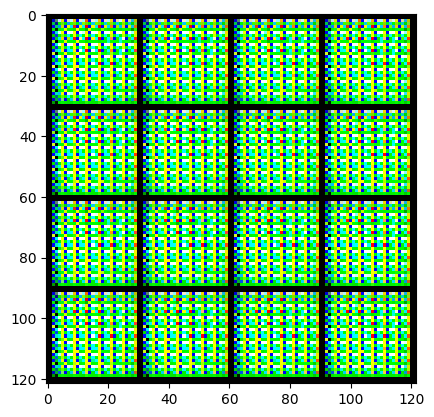

In [ ]:
# #Generator Network to generate handwritten images

# noise = torch.randn(batch_size, noise_dim, device = device)
# generated_image = G(noise)
# show_tensor_images(generated_image)